## **Customer Segmentation using RFM Model & K-Means Clustering**

#### 1. **Problem Statement**

In today's competitive retail environment, UK online stores struggle to retain existing customers and personalize marketing efforts. This project addresses this challenge by developing a customer segmentation model using RFM analysis and K-means clustering to identify distinct customer groups based on purchasing behavior. This will enable targeted marketing strategies to improve customer engagement and retention.

---

#### 2. **Collect Data**

This Markdown file provides an overview of the Online Retail dataset available on the UCI Machine Learning Repository. The company primarily sells unique all-occasion gifts. The majority of the customers are wholesalers.

`Data Source:` [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/352/online+retail)

`Dataset Summary`

The Online Retail dataset contains all transactions occurring between **December 1st, 2010, and December 9th, 2011**, for a UK-based non-store online retailer. 


| Feature | Description |
|---|---|
| Type | Multivariate, Sequential, Time-Series |
| Subject Area | Business |
| Associated Tasks | Clustering |
| Number of Instances | 541,909 (transactions) |
| Number of Features | 6 |

`Features`

The dataset includes the following features:

| Feature Name | Description | Type |
|---|---|---|
| InvoiceNo | Unique invoice number (cancellation indicated by 'c' prefix) | Categorical |
| StockCode | Unique product code | Categorical |
| Description | Product name | Categorical |
| Quantity | Number of items purchased per transaction | Integer |
| InvoiceDate | Date and time of transaction | Datetime |
| UnitPrice | Price per unit of product (British pounds sterling) | Continuous |
| CustomerID | Unique customer number | Categorical |
| Country | Customer's country of residence | Categorical |

---

#### 3. **Load Dataset** 

`Importing Libraries`

Import the necessary libraries using the `import` keyword. 

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

`Load Dataset`

Load the dataset into a pandas dataframe using the `pd.read_excel` function.      

In [3]:
df = pd.read_excel("online_retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


---

#### 4. **Perform Exploratory Data Analysis (EDA)**

In [4]:
df.shape

(541909, 8)

There are `541909 rows` and `8 columns` in the dataset.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
# CustomerID should be string type, we need to convert it to string by using astype

df["CustomerID"] = df["CustomerID"].astype(str)

The customer ID column has been converted to string type.

In [8]:
df.describe()

,Quantity,InvoiceDate,UnitPrice
count,541909.000000,541909,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114
min,-80995.000000,2010-12-01 08:26:00,-11062.060000
25%,1.000000,2011-03-28 11:34:00,1.250000
50%,3.000000,2011-07-19 17:17:00,2.080000
75%,10.000000,2011-10-19 11:27:00,4.130000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,218.081158,NaN,96.759853


In [9]:
df.isnull().sum()/len(df) * 100

InvoiceNo      0.000000
StockCode      0.000000
Description    0.268311
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.000000
Country        0.000000
dtype: float64

We have `0.26% null values` in the description column. We can simply drop them.

In [10]:
df.dropna(inplace = True)
df.shape

(540455, 8)

In [12]:
df.duplicated().sum()

5268

We have `5268 duplicated rows`. We can simply drop them.

In [13]:
df.drop_duplicates(inplace = True)
df.shape

(535187, 8)

In [14]:
df["CustomerID"].nunique()

4373

We have a total of `4373 unique customers`. 

---

#### 5. **Data Preprocessing**

As we do not have values of Recency, Frequency and Monetary in our original dataset, first we need to calculate them. 

`RFM Calculations and Feature Creation`

`Monetary Value` 

In [15]:
df["Monetary"] = df["Quantity"] * df["UnitPrice"]
mon_df = df.groupby("CustomerID")["Monetary"].sum().reset_index()
mon_df.head()

,CustomerID,Monetary
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


`Frequency`

In [17]:
freq_df = df.groupby("CustomerID")["InvoiceNo"].count().reset_index()
freq_df.columns = ["CustomerID", "Frequency"]
freq_df.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


`Recency`

In [19]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format = "%d-%m-%Y %H:%M")
df["InvoiceDate"].head()

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]

In [20]:
max_date = df["InvoiceDate"].max()
max_date

Timestamp('2011-12-09 12:50:00')

In [21]:
df["diff"] = max_date - df["InvoiceDate"]

In [22]:
rec_df = df.groupby("CustomerID")["diff"].min().reset_index()
rec_df["diff"] = rec_df["diff"].dt.days
rec_df.rename(columns={"diff": "Recency"}, inplace = True)
rec_df.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


`Create new RFM dataframe (rfm_df)`

In [23]:
merged_df = pd.merge(freq_df, mon_df, on = "CustomerID", how = "inner")
rfm_df = pd.merge(merged_df, rec_df, on = "CustomerID", how = "inner")
rfm_df.set_index("CustomerID", inplace=True)

rfm_df.head()

,Frequency,Monetary,Recency
CustomerID,,,
12346.0,2,0.00,325
12347.0,182,4310.00,1
12348.0,31,1797.24,74
12349.0,73,1757.55,18
12350.0,17,334.40,309


In [24]:
rfm_df.shape

(4373, 3)

`Data Cleaning`

In [25]:
# Keep only positive values

rfm_df = rfm_df[(rfm_df > 0).all(axis = 1)]

rfm_df.shape

(4217, 3)

`rfm_df` is the new RFM dataframe. It has `4217 rows` and `3 columns`.

`Checking Outliers`

<Axes: >

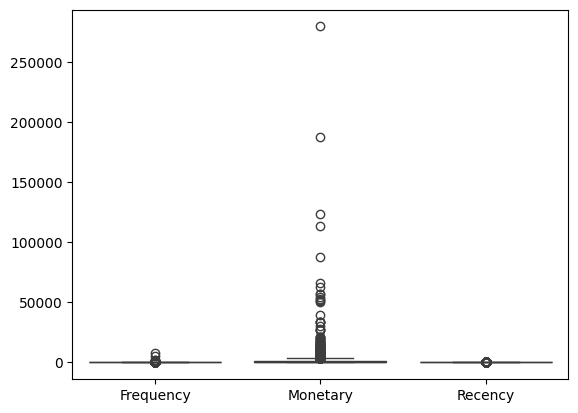

In [26]:
sns.boxplot(data = rfm_df[["Frequency", "Monetary", "Recency"]])

`Removing Outliers using IQR method`

In [27]:
# Removing outliers for Monetary

q1 = rfm_df["Monetary"].quantile(0.25)
q3 = rfm_df["Monetary"].quantile(0.75)

iqr = q3 - q1

rfm_df = rfm_df[(rfm_df["Monetary"] >= q1 - 1.5 * iqr) & (rfm_df["Monetary"] <= q3 + 1.5 * iqr)]

# Removing outliers for Monetary

q1 = rfm_df["Frequency"].quantile(0.25)
q3 = rfm_df["Frequency"].quantile(0.75)

iqr = q3 - q1

rfm_df = rfm_df[(rfm_df["Frequency"] >= q1 - 1.5 * iqr) & (rfm_df["Frequency"] <= q3 + 1.5 * iqr)]

# Removing outliers for Recency

q1 = rfm_df["Recency"].quantile(0.25)
q3 = rfm_df["Recency"].quantile(0.75)

iqr = q3 - q1

rfm_df = rfm_df[(rfm_df["Recency"] >= q1 - 1.5 * iqr) & (rfm_df["Recency"] <= q3 + 1.5 * iqr)]

rfm_df.shape

(3579, 3)

`Feature Scaling using Min-Max Scaler`

In [28]:
from sklearn.preprocessing import MinMaxScaler

# Separate features (assuming numerical columns)
features = rfm_df.select_dtypes(include=['int64', 'float64'])  # Select numerical data types

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the data (calculate min and max values)
scaler.fit(features)

# Transform the features (apply Min-Max scaling)
scaled_features = scaler.transform(features)

# Optional: Add the scaled features back to the DataFrame with new column names
rfm_df['Frequency'] = scaled_features[:, 0]  # Assuming Frequency is the first feature
rfm_df['Monetary'] = scaled_features[:, 1]  # Assuming Monetary is the second feature
rfm_df['Recency'] = scaled_features[:, 2]  # Assuming Recency is the third feature

rfm_df.head()

,Frequency,Monetary,Recency
CustomerID,,,
12348.0,0.176471,0.527102,0.196237
12349.0,0.423529,0.515462,0.045699
12350.0,0.094118,0.098074,0.827957
12352.0,0.552941,0.453245,0.091398
12353.0,0.017647,0.026102,0.543011


---

#### 6. **KMeans Clustering | ML  Model Building**

`Perform kMeans Clustring with some arbitrary k = 4`

In [29]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, max_iter=50, random_state= 42)
kmeans.fit(rfm_df)

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=50, n_clusters=4, random_state=42)

`Plotting the Clusters`

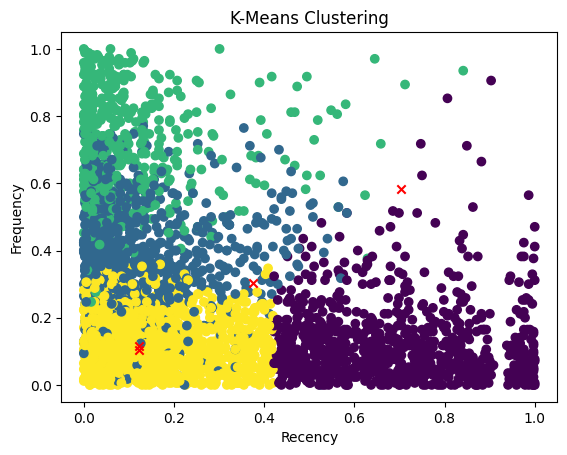

In [30]:
# Get the cluster labels

labels = kmeans.labels_
centers = kmeans.cluster_centers_

plt.scatter(rfm_df["Recency"], rfm_df["Frequency"], c=labels)
plt.scatter(centers[:, 0], centers[:, 1], marker='x', color='red')

plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('K-Means Clustering')

plt.show()

The random number of cluters show that the data is not well clustered. 

`Choosing the Number of Clusters (k) Using Elbow Method`

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\clus

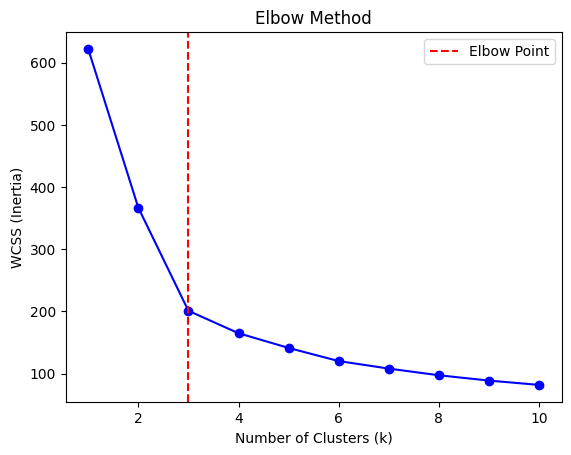

The best number of clusters based on the Elbow Method is: 3


In [31]:
X = rfm_df[["Recency", "Frequency", "Monetary"]]

k_values = range(1, 11)  # Test k from 1 to 10
wcss = []  # List to store the inertia values

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(k_values, wcss, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method')

# Find the elbow point
diff = [wcss[i] - wcss[i+1] for i in range(len(wcss)-1)]
best_k = diff.index(max(diff)) + 3

# Add a vertical line to indicate the elbow point
plt.axvline(x=best_k, color='r', linestyle='--', label='Elbow Point')

plt.legend()
plt.show()

print("The best number of clusters based on the Elbow Method is:", best_k)


`Silhouette Index Score`     

**The Silhouette score (between -1 and 1) measures how well data points fit their clusters.**

A score closer to 1 means good separation (points are close within their cluster and far from others).
A score near 0 indicates overlapping clusters (data points could belong to either).
Negative scores suggest misassignments (points are closer to other clusters).

In [32]:
from sklearn.metrics import silhouette_score

# Perform k-means clustering and get labels in one step
kmeans = KMeans(n_clusters=3, random_state=42).fit_predict(rfm_df)

# Calculate Silhouette Score
silhouette_score = silhouette_score(rfm_df, kmeans)

print("The Silhouette Score for k=3 is:", silhouette_score)

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The Silhouette Score for k=3 is: 0.4576714985062091


`Perform kMeans Clustring with k = 3`

In [33]:
kmeans = KMeans(n_clusters=3, max_iter=50, random_state= 42)
kmeans.fit(rfm_df)

# Add cluster labels to the dataset
rfm_df['Label'] = kmeans.labels_

rfm_df.head()

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Frequency,Monetary,Recency,Label
CustomerID,,,,
12348.0,0.176471,0.527102,0.196237,2
12349.0,0.423529,0.515462,0.045699,1
12350.0,0.094118,0.098074,0.827957,0
12352.0,0.552941,0.453245,0.091398,1
12353.0,0.017647,0.026102,0.543011,0


In [34]:
rfm_df["Label"].value_counts()

Label
2    1849
0     954
1     776
Name: count, dtype: int64

`Stripplot to visualize the Monetary vs. Label`

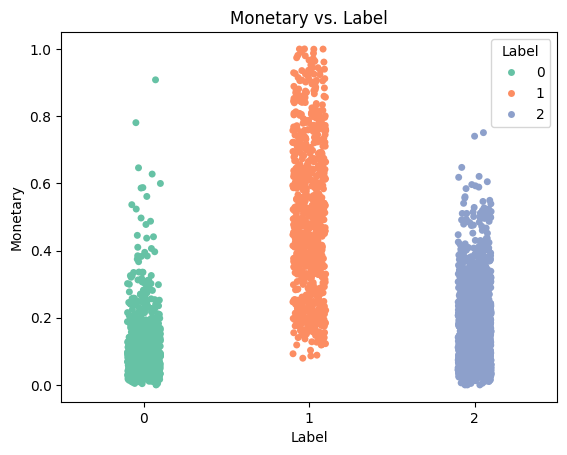

In [35]:
sns.stripplot(x="Label", y="Monetary", data=rfm_df, hue="Label", palette="Set2")

plt.xlabel('Label')

plt.ylabel('Monetary')

plt.title('Monetary vs. Label')

plt.show()

`Stripplot to visualize the Frequency vs. Label`

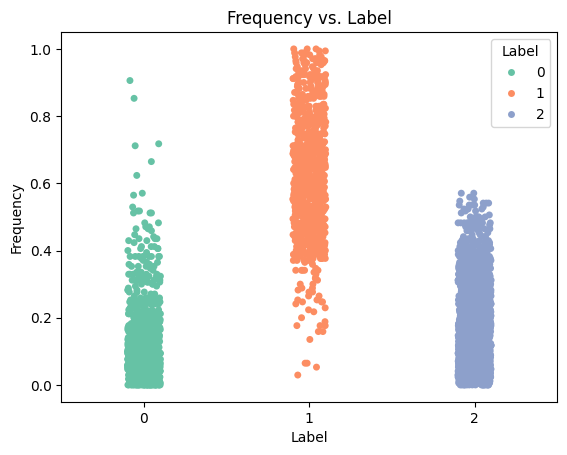

In [36]:
sns.stripplot(x="Label", y="Frequency", data=rfm_df, hue="Label", palette="Set2")

plt.xlabel('Label')

plt.ylabel('Frequency')

plt.title('Frequency vs. Label')

plt.show()

`Stripplot to visualize the Recency vs. Label`

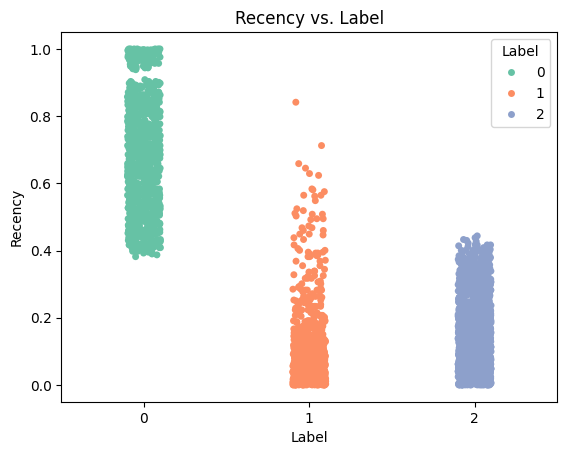

In [37]:
sns.stripplot(x="Label", y="Recency", data=rfm_df, hue="Label", palette="Set2")

plt.xlabel('Label')

plt.ylabel('Recency')

plt.title('Recency vs. Label')

plt.show()

`Clustring of Customers on the basis of Label in x-y plane`

In [44]:
import plotly.express as px

fig = px.scatter(rfm_df, x='Frequency', y='Recency', color='Label')
fig.show()

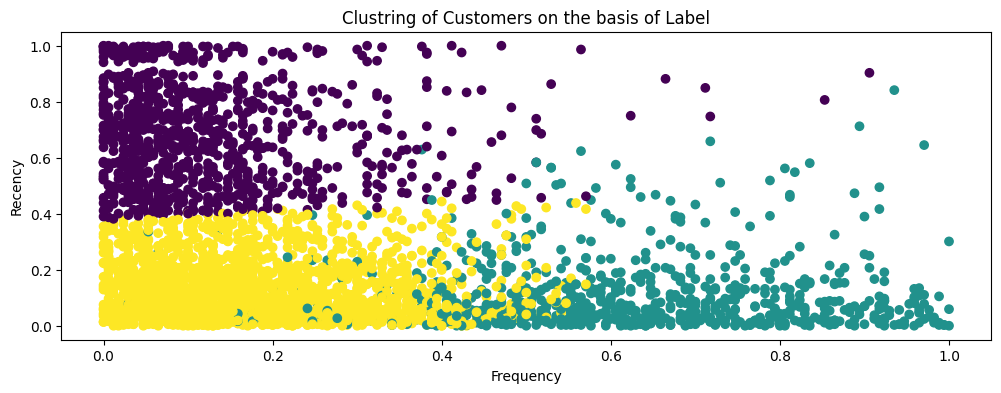

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.scatter(rfm_df['Frequency'], rfm_df['Recency'], c=rfm_df['Label'])
plt.xlabel('Frequency')
plt.ylabel('Recency')
plt.title('Clustring of Customers on the basis of Label')

plt.show()



`Clustring of Customers on the basis of Label in 3D plane`

In [41]:
import plotly.express as px

fig = px.scatter_3d(rfm_df, x='Frequency', y='Recency', z='Monetary', color='Label')
fig.show()

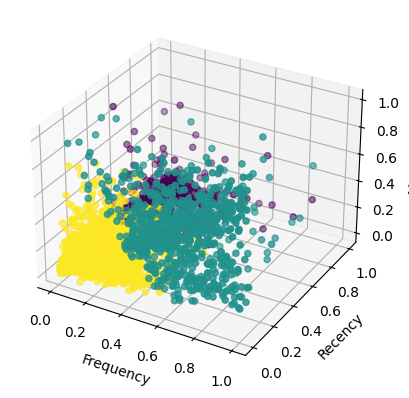

In [40]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm_df['Frequency'], rfm_df['Recency'], rfm_df['Monetary'], c=rfm_df['Label'])

ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Monetary')

plt.show()

---

#### 7. **Conclusion**

This project implemented customer segmentation using the RFM Model and K-means Clustering on a UK online retail store's transaction data. The analysis resulted in three distinct customer clusters: `Cluster 0, Cluster 1, and Cluster 2`. Notably, Cluster 0 exhibited the highest revenue generation, while Cluster 2 demonstrated the lowest.

Customer segmentation proves to be a powerful tool for gaining business insights into customer behavior. The `Silhouette Index score of 0.45` indicates a good separation between the clusters within this dataset.


**`Key takeaways from the analysis:`**


`Cluster 1:` These customers are likely `loyal advocates`, **exhibiting recent purchases, **high purchase frequency**, and significant total spending. They represent a valuable customer segment for nurturing strong relationships.

`Cluster 0:` This cluster likely consists of at-risk customers or those `prone to churn`. They demonstrate **low recent purchase activity, infrequent purchases, and lower total spending compared to other clusters**. Targeted marketing campaigns aimed at re-engagement may be beneficial for this group.



**`Benefits of Customer Segmentation:`**

Customer segmentation offers several advantages that can significantly improve business strategies. Here are some key benefits:

* **Targeted Marketing:** By understanding customer segments, businesses can tailor marketing campaigns to specific groups, increasing campaign effectiveness.
* **Improved Customer Relationships:** Segmentation allows for personalized interactions and promotions, fostering stronger customer relationships.
* **Enhanced Customer Retention:** Identifying high-value customers or at-risk customers allows for targeted efforts to improve retention.

By leveraging customer segmentation, businesses gain valuable insights into their customer base, enabling them to develop targeted strategies that enhance customer experience, drive sales, and ultimately lead to increased profitability.
